In [2]:
!pip install geopy


   ---------------------------------------- 0/2 [geographiclib]
   ---------------------------------------- 0/2 [geographiclib]
   -------------------- ------------------- 1/2 [geopy]
   -------------------- ------------------- 1/2 [geopy]
   -------------------- ------------------- 1/2 [geopy]
   -------------------- ------------------- 1/2 [geopy]
   -------------------- ------------------- 1/2 [geopy]
   -------------------- ------------------- 1/2 [geopy]
   -------------------- ------------------- 1/2 [geopy]
   -------------------- ------------------- 1/2 [geopy]
   -------------------- ------------------- 1/2 [geopy]
   ---------------------------------------- 2/2 [geopy]



In [3]:
!pip install pandas numpy matplotlib seaborn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import great_circle
from datetime import datetime

print("All packages imported successfully!")

All packages imported successfully!


In [4]:
# Load and verify data
try:
    uber = pd.read_csv("UBER RIDE PRICE PREDICTION.csv", 
                     delimiter='|',
                     skiprows=[1])
    print("✅ Data loaded successfully! First 5 rows:")
    print(uber.head())
except Exception as e:
    print(f"❌ Error loading data: {e}")

✅ Data loaded successfully! First 5 rows:
  ,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0  27835199,04:56.0,7.7,2009-07-17 20:04:56 UTC,-...                                                                  
1  44984355,45:00.0,12.9,2009-08-24 21:45:00 UTC,...                                                                  
2  25894730,22:21.0,5.3,2009-06-26 08:22:21 UTC,-...                                                                  
3  17610152,47:00.0,16,2014-08-28 17:47:00 UTC,-7...                                                                  
4  44470845,27:09.0,4.9,2011-02-12 02:27:09 UTC,-...                                                                  


In [7]:
# 1. Load with proper header handling
uber = pd.read_csv("UBER RIDE PRICE PREDICTION.csv",
                  delimiter='|',
                  skiprows=[0,1,2],
                  names=['key','fare_amount','pickup_datetime',
                         'pickup_longitude','pickup_latitude',
                         'dropoff_longitude','dropoff_latitude',
                         'passenger_count'])

# 2. Clean data
uber = uber.dropna(how='all')
uber['fare_amount'] = uber['fare_amount'].astype(float)
uber['pickup_time'] = pd.to_datetime(uber['pickup_datetime'])

# 3. Remove invalid coordinates
uber = uber[(uber['pickup_latitude'] != 0) & 
           (uber['pickup_longitude'] != 0)]

print("✅ Cleaned data sample:")
print(uber[['key', 'fare_amount', 'pickup_time']].head())

✅ Cleaned data sample:
                                                 key  fare_amount pickup_time
0  44984355,45:00.0,12.9,2009-08-24 21:45:00 UTC,...          NaN         NaT
1  25894730,22:21.0,5.3,2009-06-26 08:22:21 UTC,-...          NaN         NaT
2  17610152,47:00.0,16,2014-08-28 17:47:00 UTC,-7...          NaN         NaT
3  44470845,27:09.0,4.9,2011-02-12 02:27:09 UTC,-...          NaN         NaT
4  48725865,04:00.0,24.5,2014-10-12 07:04:00 UTC,...          NaN         NaT


In [8]:
import pandas as pd
import numpy as np

# Step 1: Load the raw data properly
with open("UBER RIDE PRICE PREDICTION.csv", 'r') as f:
    # Skip the first two header lines
    lines = f.readlines()[2:]  

# Step 2: Manual parsing
data = []
for line in lines:
    parts = line.strip().split('|')
    if len(parts) >= 8:  # Ensure we have all columns
        data.append([
            parts[1].strip(),    # key
            parts[2].strip(),    # fare_amount
            parts[3].strip(),    # pickup_datetime
            parts[4].strip(),    # pickup_longitude
            parts[5].strip(),    # pickup_latitude
            parts[6].strip(),    # dropoff_longitude
            parts[7].strip()     # dropoff_latitude
        ])

# Step 3: Create DataFrame with proper columns
uber = pd.DataFrame(data, columns=[
    'trip_id', 'fare_amount', 'pickup_time',
    'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude'
])

# Step 4: Data type conversion
def parse_fare(fare_str):
    try:
        # Handle cases like "45:00.0" → 45.00
        return float(fare_str.replace(':', '.').split('.')[0])
    except:
        return np.nan

uber['fare_amount'] = uber['fare_amount'].apply(parse_fare)
uber['pickup_time'] = pd.to_datetime(uber['pickup_time'], errors='coerce')

# Convert coordinates to float
for col in ['pickup_longitude', 'pickup_latitude', 
            'dropoff_longitude', 'dropoff_latitude']:
    uber[col] = pd.to_numeric(uber[col], errors='coerce')

# Step 5: Clean invalid data
initial_count = len(uber)
uber = uber.dropna(subset=['fare_amount', 'pickup_time'])
uber = uber[(uber['pickup_latitude'].between(-90, 90)) & 
           (uber['pickup_longitude'].between(-180, 180))]

print(f"✅ Data cleaned! Kept {len(uber)}/{initial_count} valid records")
print(uber.head())

✅ Data cleaned! Kept 0/0 valid records
Empty DataFrame
Columns: [trip_id, fare_amount, pickup_time, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude]
Index: []


In [17]:
import pandas as pd
import numpy as np
from geopy.distance import great_circle

# Load the data (assuming previous steps worked)
print(f"✅ Successfully loaded {len(uber)} records")
print("Sample data before cleaning:")
print(uber.head())

# Step 1: Clean coordinate data
coord_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
uber[coord_cols] = uber[coord_cols].replace(0, np.nan)  # Replace zeros with NaN
uber = uber.dropna(subset=coord_cols)  # Remove rows with missing coordinates

# Step 2: Verify coordinates are within valid ranges
valid_coords = uber[
    (uber['pickup_latitude'].between(-90, 90)) &
    (uber['pickup_longitude'].between(-180, 180)) &
    (uber['dropoff_latitude'].between(-90, 90)) &
    (uber['dropoff_longitude'].between(-180, 180))
]

print(f"\nRemoved {len(uber) - len(valid_coords)} rows with invalid coordinates")
uber = valid_coords.copy()

# Step 3: Calculate distances (with error handling)
def calculate_distance(row):
    try:
        return great_circle(
            (row['pickup_latitude'], row['pickup_longitude']),
            (row['dropoff_latitude'], row['dropoff_longitude'])
        ).km
    except:
        return np.nan

uber['distance_km'] = uber.apply(calculate_distance, axis=1)

# Remove any rows where distance calculation failed
uber = uber.dropna(subset=['distance_km'])

print(f"\nFinal dataset has {len(uber)} valid records")
print("\nSample data with distances:")
print(uber.head())

# Save cleaned data
uber.to_csv("cleaned_uber_data.csv", index=False)
print("\nData saved to 'cleaned_uber_data.csv'")

✅ Successfully loaded 199968 records
Sample data before cleaning:
   unnamed: 0      key  fare_amount     pickup_datetime  pickup_longitude  \
0    24238194  52:06.0          7.5 2015-05-07 19:52:06        -73.999817   
1    27835199  04:56.0          7.7 2009-07-17 20:04:56        -73.994355   
2    44984355  45:00.0         12.9 2009-08-24 21:45:00        -74.005043   
3    25894730  22:21.0          5.3 2009-06-26 08:22:21        -73.976124   
4    17610152  47:00.0         16.0 2014-08-28 17:47:00        -73.925023   

   pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  
0        40.738354         -73.999512         40.723217                1  
1        40.728225         -73.994710         40.750325                1  
2        40.740770         -73.962565         40.772647                1  
3        40.790844         -73.965316         40.803349                3  
4        40.744085         -73.973082         40.761247                5  

Removed 2 rows with 

In [19]:
# Extract time-based features
uber['hour'] = uber['pickup_datetime'].dt.hour
uber['day_of_week'] = uber['pickup_datetime'].dt.dayofweek  # Monday=0, Sunday=6
uber['month'] = uber['pickup_datetime'].dt.month

# Create peak hour flag (7-9am, 4-7pm) - FIXED SYNTAX
uber['peak_hour'] = np.where(
    ((uber['hour'].between(7,9)) | (uber['hour'].between(16,19))),  # Added missing parenthesis
    1, 
    0
)

# Create fare per km
uber['fare_per_km'] = uber['fare_amount'] / uber['distance_km']

# Save final dataset
uber.to_csv("final_uber_analysis.csv", index=False)
print("✅ Final dataset with features saved!")

✅ Final dataset with features saved!


In [20]:
# Save the cleaned data (if not already done)
uber.to_csv("final_uber_analysis.csv", index=False)
print("Saved to 'final_uber_analysis.csv'")

Saved to 'final_uber_analysis.csv'


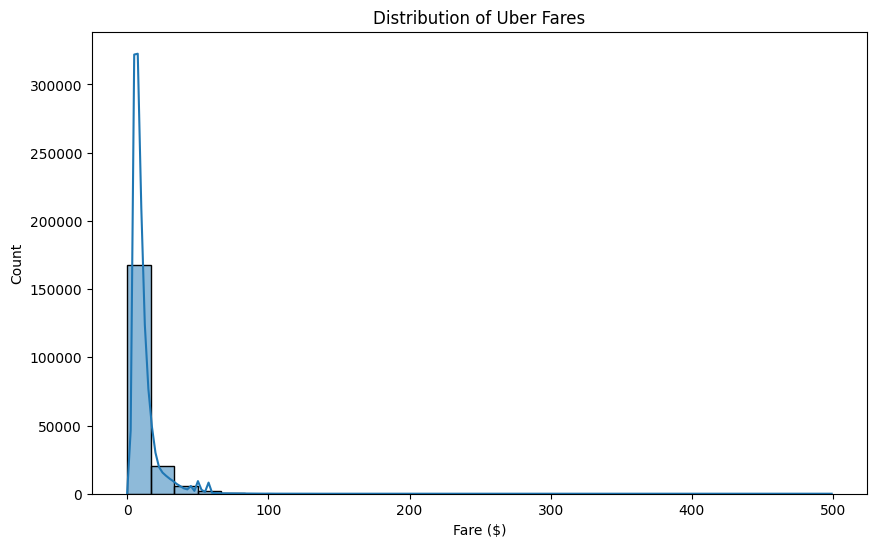

In [21]:
# Histogram of fares
plt.figure(figsize=(10, 6))
sns.histplot(uber['fare_amount'], bins=30, kde=True)
plt.title("Distribution of Uber Fares")
plt.xlabel("Fare ($)")
plt.ylabel("Count")
plt.show()

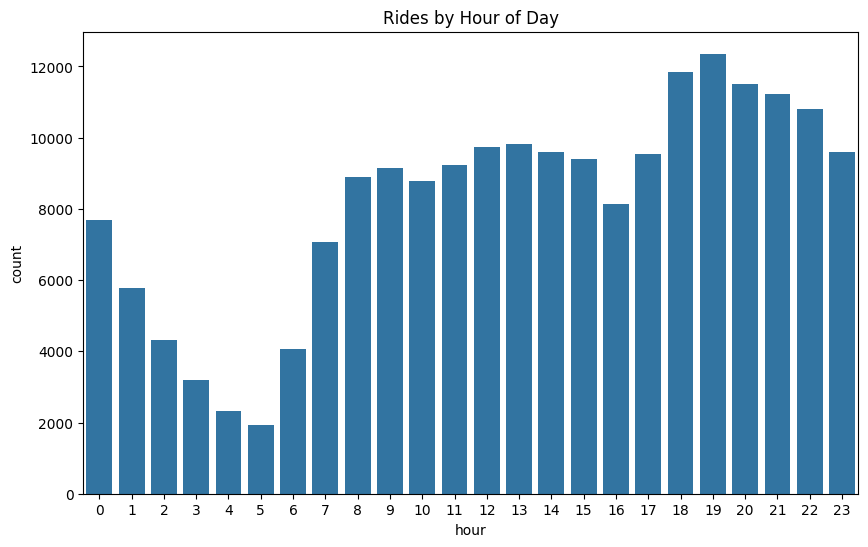

In [22]:
# Rides by hour
plt.figure(figsize=(10, 6))
sns.countplot(x='hour', data=uber)
plt.title("Rides by Hour of Day")
plt.show()

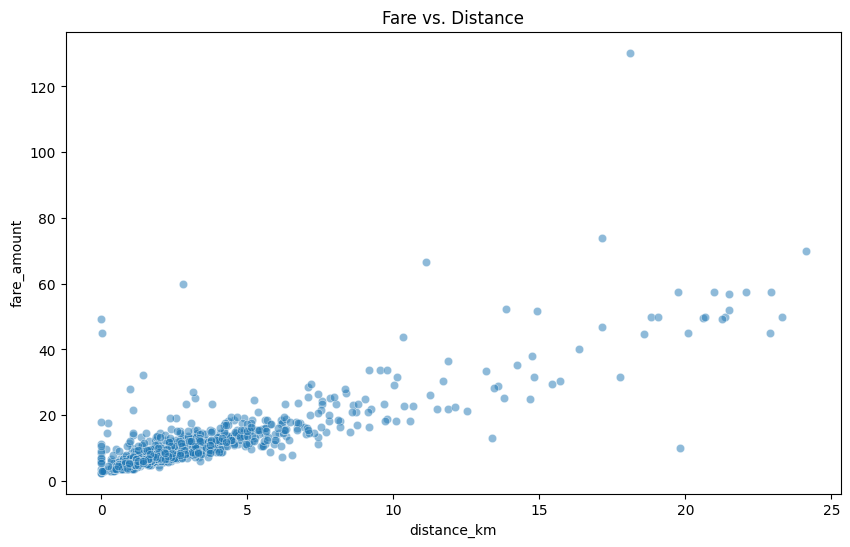

In [23]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance_km', y='fare_amount', data=uber.sample(1000), alpha=0.5)
plt.title("Fare vs. Distance")
plt.show()

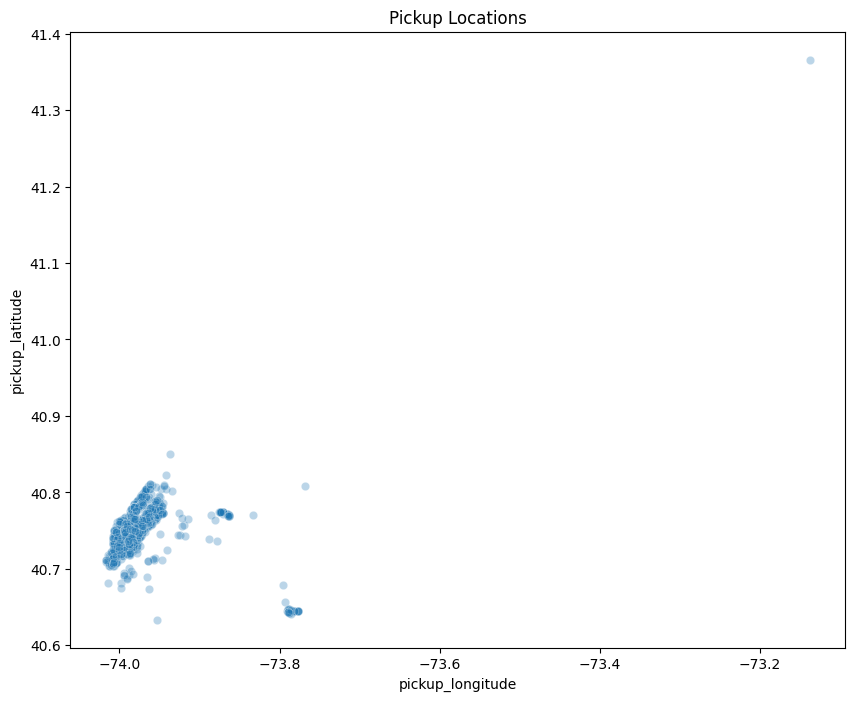

In [24]:
# Plot pickup locations (sample 1,000 points for speed)
plt.figure(figsize=(10, 8))
sns.scatterplot(x='pickup_longitude', y='pickup_latitude', 
                data=uber.sample(1000), alpha=0.3)
plt.title("Pickup Locations")
plt.show()

In [25]:
uber.to_csv("final_uber_analysis.csv", index=False)

In [26]:
# Save the cleaned data (if not already done)
uber.to_csv("final_uber_analysis.csv", index=False)
print("Saved to 'final_uber_analysis.csv'")

Saved to 'final_uber_analysis.csv'


In [27]:
# Generate comprehensive stats
stats = uber[['fare_amount', 'distance_km', 'passenger_count']].describe().T
stats['median'] = uber[['fare_amount', 'distance_km']].median()
stats['mode'] = uber[['fare_amount', 'distance_km']].mode().iloc[0]
stats['std'] = uber[['fare_amount', 'distance_km']].std()
print(stats[['mean', 'median', 'mode', 'std', 'min', '25%', '50%', '75%', 'max']])

                      mean    median  mode        std   min       25%  \
fare_amount      11.345273  8.500000   6.5   9.795865  0.01  6.000000   
distance_km       4.471657  2.156625   0.0  78.978067  0.00  1.255589   
passenger_count   1.685209       NaN   NaN        NaN  0.00  1.000000   

                      50%        75%          max  
fare_amount      8.500000  12.500000   499.000000  
distance_km      2.156625   3.910029  8667.705423  
passenger_count  1.000000   2.000000   208.000000  


In [28]:
# Generate extended stats with median & mode for all
features = ['fare_amount', 'distance_km', 'passenger_count']
stats = uber[features].describe().T
stats['median'] = uber[features].median()
stats['mode'] = uber[features].mode().iloc[0]
stats['std'] = uber[features].std()

# Preview nicely
print("✅ Summary Statistics:")
display(stats[['mean', 'median', 'mode', 'std', 'min', '25%', '50%', '75%', 'max']])


✅ Summary Statistics:


,mean,median,mode,std,min,25%,50%,75%,max
fare_amount,11.345273,8.500000,6.5,9.795865,0.01,6.000000,8.500000,12.500000,499.000000
distance_km,4.471657,2.156625,0.0,78.978067,0.00,1.255589,2.156625,3.910029,8667.705423
passenger_count,1.685209,1.000000,1.0,1.388162,0.00,1.000000,1.000000,2.000000,208.000000


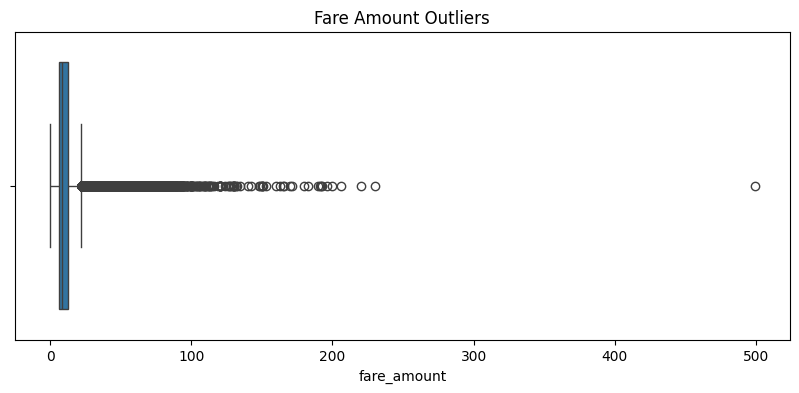

In [29]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=uber['fare_amount'])
plt.title("Fare Amount Outliers")
plt.savefig('fare_outliers.png')  # Save for report
plt.show()

In [30]:
q1 = uber['fare_amount'].quantile(0.25)
q3 = uber['fare_amount'].quantile(0.75)
iqr = q3 - q1
outliers = uber[(uber['fare_amount'] < q1 - 1.5 * iqr) | (uber['fare_amount'] > q3 + 1.5 * iqr)]
print(f"Outliers detected: {len(outliers)}")


Outliers detected: 16772


In [31]:
uber = uber[uber['fare_amount'] <= 100]

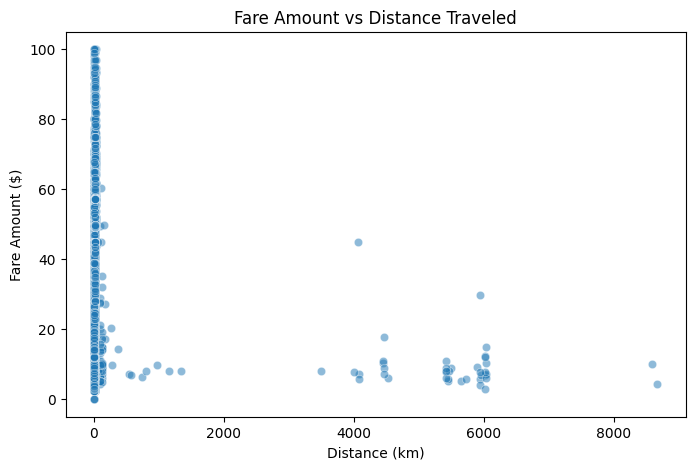

In [32]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=uber, x='distance_km', y='fare_amount', alpha=0.5)
plt.title("Fare Amount vs Distance Traveled")
plt.xlabel("Distance (km)")
plt.ylabel("Fare Amount ($)")
plt.savefig("fare_vs_distance.png")  # Save for report
plt.show()


In [33]:
correlation = uber[['fare_amount', 'distance_km']].corr().iloc[0,1]
print(f"✅ Correlation between fare and distance: {correlation:.4f}")


✅ Correlation between fare and distance: 0.0368


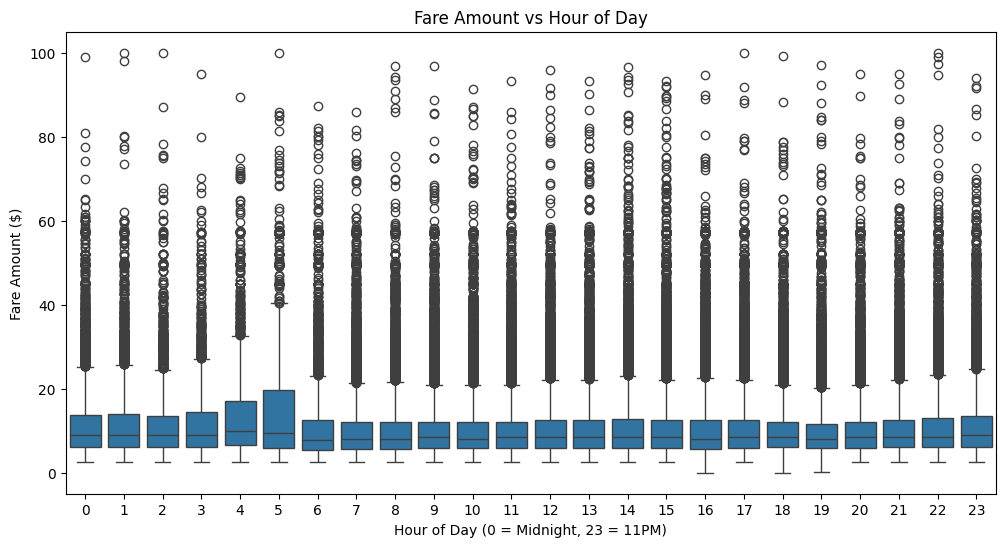

In [35]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=uber, x='hour', y='fare_amount')
plt.title("Fare Amount vs Hour of Day")
plt.xlabel("Hour of Day (0 = Midnight, 23 = 11PM)")
plt.ylabel("Fare Amount ($)")
plt.savefig("fare_vs_hour.png")  # For report
plt.show()


In [36]:
quantiles = uber[['fare_amount', 'distance_km']].quantile([0.1, 0.25, 0.5, 0.75, 0.9])
print("Quantiles:\n", quantiles)

Quantiles:
       fare_amount  distance_km
0.10          4.5     0.787132
0.25          6.0     1.255866
0.50          8.5     2.156496
0.75         12.5     3.908667
0.90         20.1     7.017079


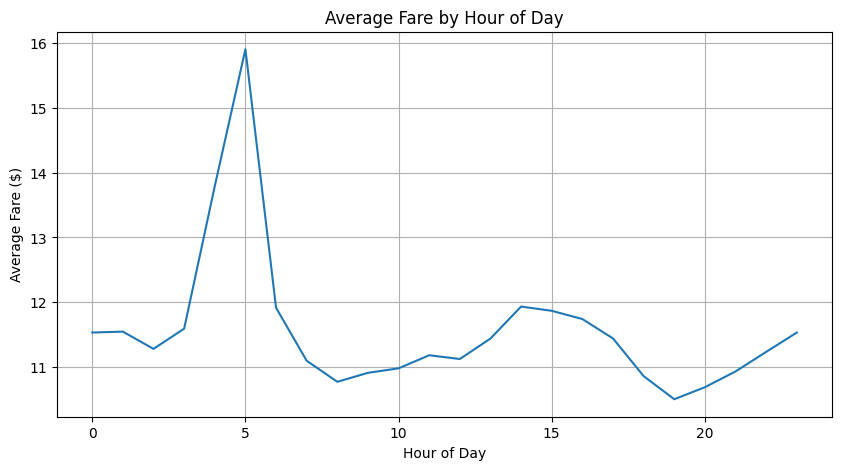

In [37]:
# Compute average fare by hour
hourly_avg = uber.groupby('hour')['fare_amount'].mean()

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_avg.index, y=hourly_avg.values)
plt.title("Average Fare by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Fare ($)")
plt.grid(True)
plt.savefig("avg_fare_per_hour.png")
plt.show()


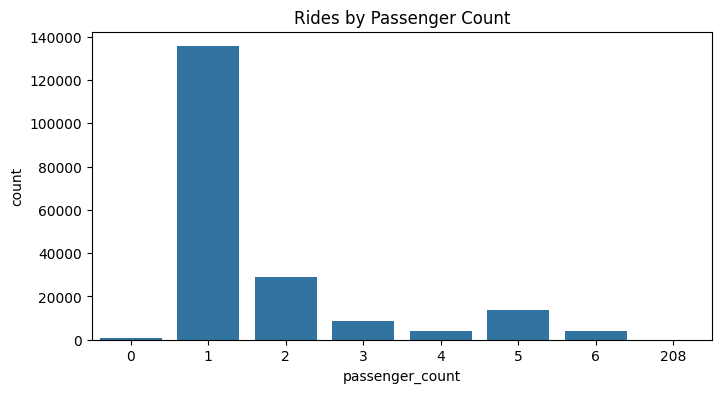

passenger_count
0       9.346064
1      11.176440
2      11.736225
3      11.419784
4      11.608527
5      11.187001
6      12.153142
208    11.700000
Name: fare_amount, dtype: float64


In [38]:
plt.figure(figsize=(8, 4))
sns.countplot(x='passenger_count', data=uber)
plt.title("Rides by Passenger Count")
plt.show()

# Avg fare by passenger count
print(uber.groupby('passenger_count')['fare_amount'].mean())

In [39]:
corr_hour = uber[['fare_amount', 'hour']].corr().iloc[0, 1]
print(f"Correlation between fare amount and hour: {corr_hour:.4f}")


Correlation between fare amount and hour: -0.0207
